# What is this project about?
### Plant disease recognition
This project is about collecting images of various infected, good and seems to be infected plant leafs. Then apply image processing on the images and predict the infected plant leafs using Deep Learning+ImageProcessing.

### Introduction: 
Plants are the source of food Plants are the source of food on the planet. Infections and diseases in plants are therefore a serious threat, while the most common diagnosis is primarily performed by examining the plant body for the presence of visual symptoms. As an alternative to the traditionally time-consuming process, different research works attempt to find feasible approaches towards protecting plants. In recent years, growth in technology has engendered several alternatives to traditional arduous methods. Deep learning techniques have been very successful in image classification problems. This work uses Deep Convolutional Neural Network (CNN) to detect plant diseases from images of plant leaves.

# Our approach to building this plant disease detection classification model is discussed in four steps:
- Explore the dataset
- Build a CNN model
- Train and validate the model
- Get accuracy of model

## <font color=green>Importing neccessary packages</font>

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time
import matplotlib.pyplot as plt

# Step 1: Explore the dataset<br>
Our `train` folder contains 15 folders each representing a different class. The range of the folder is from 0 to 14. With the help of the OS module, we iterate over all the classes and append images and their respective labels in the data and labels list.


## <font color=green>Epochs and size of NN is defined</font><br>
#### direct data download link : https://www.dropbox.com/s/akac6riqjssahsh/plantdisease_dataset.zip?dl=0 <br> 
#### Source: https://www.tensorflow.org/datasets/catalog/plant_village

In [2]:
EPOCHS = 20
INIT_LR = .001
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'D:\Gamez\plantdisease'
width = 256
height= 256
depth = 3

### <font color=green>Function to convert images to array</font><br>



In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)  #cv2 used as keword for OpenCV Library already imported in main code
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


## <font color=green>Naming of Tensorboard directory</font><br>



In [4]:
NAME = "CVPR".format(int(time.time()))
NAME1 = "CVPR1".format(int(time.time()))

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

# Step 2: Build a CNN model

**We will Build 3 models here**
> **The Sequential model** = A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

> Layers early in the network architecture (i.e., closer to the actual input image) learn fewer **convolutional filters** while layers deeper in the network (i.e., closer to the output predictions) will learn more filters.


> Dropout is a technique where randomly selected neurons are ignored during training. They are **dropped-out** randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.


> We compile the model with Adam optimizer which performs well and loss is `categorical_crossentropy` because we have multiple classes to categorise.

### Defining models && Split datas 

In [6]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0

# Steps 3: Train and validate the model

## <font color=red>Iteration rate .001:</font><br>

After building the model architecture, we then train the model using `model.fit()`


- We will train above three models here

#### Training Data.....

In [8]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    callbacks=[tensorboard],
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
 1/73 [..............................] - ETA: 0s - loss: 0.4108 - accuracy: 0.0938WARNING:tensorflow:From C:\Users\RAJ\anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
73/73 [==============================] - 242s 3s/step - loss: 0.2131 - accuracy: 0.3985 - val_loss: 0.5170 - val_accuracy: 0.1002
Epoch 2/20
73/73 [==============================] - 238s 3s/step - loss: 0.1905 - accuracy: 0.4558 - val_loss: 1.1847 - val_accuracy: 0.0679
Epoch 3/20
73/73 [==============================] - 231s 3s/step - loss: 0.1630 - accuracy: 0.5511 - val_loss: 0.8914 - val_accuracy: 0.1087
Epoch 4/20
73/73 [==============================] - 230s 3s/step - loss: 0.1385 - accuracy: 0.6006 - val_loss: 0.8493 - va

# Plotting Datas

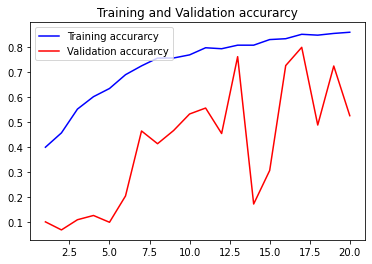

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

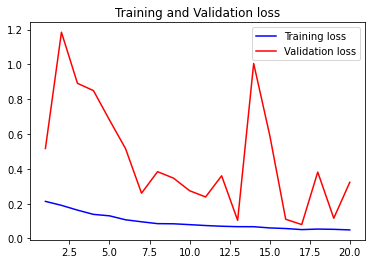

In [11]:
#Proceed after evaluation of model loss is predict:-

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# Step 4
### Calculating Model Accuracy

In [12]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 7s 355ms/step - loss: 0.3229 - accuracy: 0.5246
Test Accuracy: 52.46179699897766


## <font color=green>Train and validate the model again</font><br>

# <font color=red>Iteration rate .01:</font><br>
 

After building the model architecture, we then train the model using `model.fit()`


- We will train above three models here

In [14]:
opt = Adam(lr=.01, decay=.01 / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    callbacks=[tensorboard],
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/20
73/73 [==============================] - 225s 3s/step - loss: 0.3797 - accuracy: 0.2641 - val_loss: 1.8108 - val_accuracy: 0.1070
Epoch 2/20
73/73 [==============================] - 225s 3s/step - loss: 0.2822 - accuracy: 0.3878 - val_loss: 1.5375 - val_accuracy: 0.1002
Epoch 3/20
73/73 [==============================] - 229s 3s/step - loss: 0.2224 - accuracy: 0.4718 - val_loss: 0.5403 - val_accuracy: 0.3209
Epoch 4/20
73/73 [==============================] - 230s 3s/step - loss: 0.1905 - accuracy: 0.5261 - val_loss: 0.8868 - val_accuracy: 0.2292
Epoch 5/20
73/73 [==============================] - 223s 3s/step - loss: 0.1671 - accuracy: 0.5692 - val_loss: 0.2635 - val_accuracy: 0.4618
Epoch 6/20
73/73 [==============================] - 235s 3s/step - loss: 0.1342 - accuracy: 0.6226 - val_loss: 0.2049 - val_accuracy: 0.5280
Epoch 7/20
73/73 [==============================] - 236s 3s/step - loss: 0.1220 - accuracy: 0.6558 - val_loss: 0.2340 - val_accuracy: 0.4516
Epoch 8/20
73

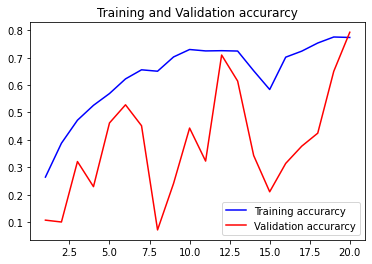

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

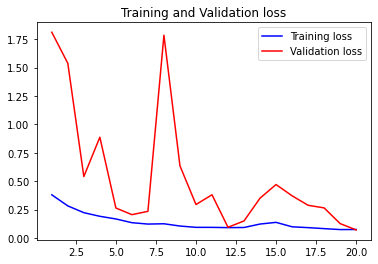

In [17]:
#Proceed after evaluation of model loss is predict:-

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [18]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 6s 315ms/step - loss: 0.0706 - accuracy: 0.7929
Test Accuracy: 79.28692698478699


## Conclusion
The Results presented in this section are related to training with the whole database containing both original and augmented images. When we iterated it with .001 then the accuracy we got is about 52% and when we trained it again with iteration rate .01 then we got accuracy about 79%. As it is known that convolutional networks are able to learn features when trained on larger datasets, results achieved when trained with only original images will not be explored. In addition, there are still no commercial solutions on the market, except those dealing with plant species recognition based on the leaves images. In this paper, a approach of using deep learning method was explored in order to automatically classify and detect plant dise	ases from leaf images. The complete procedure was described, respectively, from collecting the images used for training and validation to image pre-processing and augmentation and finally the procedure of training the deep CNN and fine-tuning. Different tests were performed in order to check the performance of newly created model. As the presented method has not been exploited, as far as we know, in the field of plant disease recognition, there was no comparison with related results, using the exact technique. 